## [Multi30k](https://torchtext.readthedocs.io/en/latest/datasets.html#multi30k)

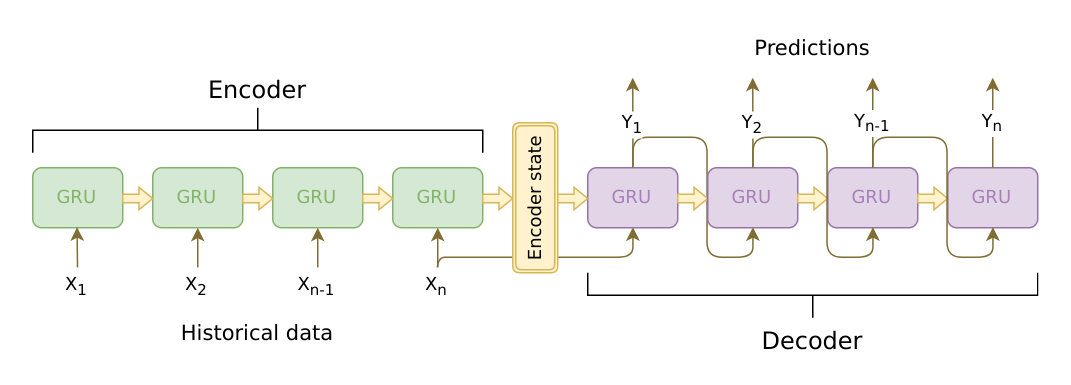

In [1]:
# https://pytorch.org/get-started/previous-versions/

In [2]:
# CUDA 11.8
#conda install pytorch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 pytorch-cuda=11.8 -c pytorch -c nvidia
# CUDA 12.1
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1
#conda install pytorch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 cpuonly -c pytorch

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install torchtext

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from typing import List, Tuple

/home/ubuntu/.local/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ubuntu/.local/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ubuntu/.local/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [7]:
!python3 -m spacy download en_core_web_sm
!python3 -m spacy download de_core_news_sm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.9 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 3.5 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [8]:
import pandas as pd
import torch
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

In [9]:
import spacy

spacy.require_gpu()

True

In [10]:
spacy_en = spacy.load("en_core_web_sm")
spacy_en.disable_pipes(*[pipe for pipe in spacy_en.pipe_names if pipe != "tokenizer"])
spacy_de = spacy.load("de_core_news_sm")
spacy_de.disable_pipes(*[pipe for pipe in spacy_de.pipe_names if pipe != "tokenizer"])

['tok2vec',
 'tagger',
 'morphologizer',
 'parser',
 'lemmatizer',
 'attribute_ruler',
 'ner']

In [11]:
def tokenizer_en(text):
    doc = spacy_en(text)
    tokens = ['<sos>'] + [token.text.lower() for token in doc] + ['<eos>']
    return tokens

def tokenizer_de(text):
    doc = spacy_de(text)
    tokens = ['<sos>'] + [token.text.lower() for token in doc] + ['<eos>']
    return tokens

In [12]:
print(tokenizer_de('büsche vieler nähe der in freien im sind männer weiße junge zwei'))

['<sos>', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei', '<eos>']


In [13]:
print(tokenizer_en('two young , white males are outside near many bushes.'))

['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']


In [14]:
def yield_tokens_en(data_iter):
    for _, en in data_iter:
        yield tokenizer_en(en)

def yield_tokens_de(data_iter):
    for de, _ in data_iter:
        yield tokenizer_de(de)


In [15]:
from torchtext.datasets import Multi30k

train_iter, valid_iter, test_iter = Multi30k(split=('train', 'valid', 'test'))

en_vocab = build_vocab_from_iterator(yield_tokens_en(train_iter), specials=["<pad>", "<unk>", "<sos>", "<eos>"])
en_vocab.set_default_index(en_vocab["<unk>"])
de_vocab = build_vocab_from_iterator(yield_tokens_de(train_iter), specials=["<pad>", "<unk>", "<sos>", "<eos>"])
de_vocab.set_default_index(en_vocab["<unk>"])

/home/ubuntu/.local/lib/python3.10/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ubuntu/.local/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/datapip

In [16]:
train_iter, valid_iter, test_iter = Multi30k(split=('train', 'valid', 'test'))

for de, en in train_iter:
    print(de)
    print(en)
    break


Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
Two young, White males are outside near many bushes.


In [17]:
print(en_vocab.get_stoi())

{'zales': 9792, 'yellowed': 9785, 'yell': 9784, 'yankees': 9780, 'yacht': 9777, 'xylophones': 9776, 'wuth': 9775, 'writings': 9774, 'writer': 9772, 'wristwatch': 9771, 'wristbands': 9770, 'wrinkled': 9769, 'wrecks': 9767, 'wrecked': 9766, 'wrappers': 9765, 'wrapper': 9764, 'wrangled': 9763, 'worshipers': 9759, 'worlds': 9758, 'woolly': 9756, 'woodwork': 9755, 'woodsy': 9754, 'won': 9750, 'wmoan': 9747, 'wizards': 9746, 'witnessed': 9744, 'wireless': 9737, 'windy': 9731, 'windsurfs': 9730, 'windsurfers': 9728, 'windshield': 9727, 'windowless': 9726, 'williams': 9725, 'wiggling': 9722, 'why': 9717, 'whites': 9715, 'whie': 9709, 'whereas': 9708, 'wheelers': 9707, 'whales': 9705, 'whale': 9704, 'whack': 9703, 'wendy': 9701, 'weld': 9699, 'weiner': 9698, 'weightlifting': 9697, 'weighed': 9694, 'weezer': 9692, 'weaves': 9685, 'waterproofs': 9678, 'watchful': 9677, 'warplane': 9674, 'warmer': 9672, 'wallpaper': 9663, 'walkways': 9662, 'waling': 9661, 'wake': 9658, 'waiters': 9657, 'waistband'

In [18]:
print(len(en_vocab))

9797


In [19]:
print(de_vocab.get_stoi())

{'ürde': 18666, 'üppiges': 18665, 'übungsmatte': 18662, 'übungsgrün': 18661, 'übrigen': 18660, 'überzeugen': 18658, 'überwältigt': 18657, 'überwiegende': 18653, 'übertriebene': 18651, 'überstehendes': 18650, 'überspringt': 18649, 'überschwemmung': 18648, 'überschwemmte': 18647, 'überschlagenen': 18645, 'überschaubaren': 18644, 'überschatteten': 18643, 'überraschten': 18642, 'überrascht': 18641, 'übermalt': 18638, 'übermalen': 18637, 'überlegen': 18635, 'überholt': 18633, 'übergießt': 18629, 'übergeschlagenen': 18628, 'überfülltes': 18625, 'überfüllter': 18624, 'überfüllte': 18623, 'übereinstimmenden': 18621, 'überdachungen': 18617, 'ölverseuchung': 18608, 'ölpumpe': 18606, 'ölkanne': 18605, 'öffentlich': 18603, 'äußerste': 18600, 'äteres': 18597, 'ärzten': 18594, 'ärmell': 18592, 'ältliche': 18588, 'älterem': 18586, 'ähnliche': 18584, 'ägyptisches': 18582, 'ägyptischem': 18581, 'zögerndes': 18578, 'zwischenfall': 18572, 'zwinkert': 18571, 'zwingt': 18570, 'zweijähriges': 18563, 'zweigb

In [20]:
print(len(de_vocab))

18669


In [21]:
def process_text(text, tokenizer, vocab):
    return torch.tensor(vocab(tokenizer(text)), dtype=torch.long)

In [22]:
def collate_batch(batch):
    src_list, trg_list = [], []
    for _src, _trg in batch:
        src_list.append(process_text(_src, tokenizer_de, de_vocab))
        trg_list.append(process_text(_trg, tokenizer_en, en_vocab))

    src_list = torch.nn.utils.rnn.pad_sequence(src_list, batch_first=False, padding_value=de_vocab['<pad>'])
    trg_list = torch.nn.utils.rnn.pad_sequence(trg_list, batch_first=False, padding_value=en_vocab['<pad>'])
    return src_list, trg_list

In [23]:
batch_size = 4

# IteratableDataset이므로 그대로 전달해도 됨, 다만 len()는 사용할 수 없음
train_loader = DataLoader(train_iter, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_iter, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [24]:
for src, trg in train_loader:
    print(src, trg)
    break

tensor([[    2,     2,     2,     2],
        [    5,     8,     5,     5],
        [   70,    36,    96,    66],
        [  522,  1167,    13,    25],
        [   32,   159,     7,    37],
        [   95,    10,    14,     5],
        [   19, 14833,    71,  3077],
        [   94,   221,    89,   164],
        [  153,   296,   281,     4],
        [   32,  3553,     7,     3],
        [   21,     4,     6,     0],
        [    4,     3,   239,     0],
        [    3,     0,     4,     0],
        [    0,     0,     3,     0]]) tensor([[   2,    2,    2,    2],
        [   4,    4,    4,    4],
        [  70,   38,   24,   24],
        [  26,   12,    9,   33],
        [  11,  927,    6,  140],
        [  25,  130,    4,    4],
        [  35,   11,   26,  883],
        [  10, 8480,   81,  887],
        [  56,   74,  734,    5],
        [  20,   12,   20,    3],
        [  82,   66,    4,    0],
        [  61, 5530,  235,    0],
        [  35,    5,    5,    0],
        [   5,    3,    3

In [25]:
print(src.shape) # seq, batch
print(trg.shape)

torch.Size([14, 4])
torch.Size([15, 4])


In [26]:
embed_dim = 256
n_src_layers = 2
n_src_vocab = len(de_vocab)
n_trg_layers = 2
n_trg_vocab = len(en_vocab)
hidden_size = 512

In [27]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, hidden_size, n_layers, device):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = device

        self.embed = nn.Embedding(n_src_vocab, embed_dim)
        self.gru = nn.GRU(input_size=embed_dim, hidden_size=hidden_size, num_layers=n_layers, dropout=0.5)
        self.dropout = nn.Dropout()
    def forward(self, x):
        batch_size = x.shape[1]
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)  
        x = self.embed(x)
        x = self.dropout(x)
        x, hidden = self.gru(x, hidden)
#        x, hidden = self.gru(x)
        return x, hidden

In [28]:
encoder = Encoder(embed_dim, hidden_size, n_src_layers, device).to(device)
X = torch.LongTensor(src).to(device)
print(X.shape)
with torch.no_grad():
    y, hidden = encoder(X)
    print(y.shape, hidden.shape)

torch.Size([14, 4])
torch.Size([14, 4, 512]) torch.Size([2, 4, 512])


In [29]:
class Decoder(nn.Module):
    def __init__(self, embed_dim, hidden_size, output_size, n_layers, device):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.device = device

        self.embed = nn.Embedding(n_trg_vocab, embed_dim)
        self.gru = nn.GRU(input_size=embed_dim, hidden_size=hidden_size, num_layers=n_layers, dropout=0.5)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Dropout()
        )
    def forward(self, x, hidden):
        x = self.embed(x)
        x, hidden = self.gru(x, hidden)
        x = self.fc(x)
        return x, hidden

In [30]:
decoder = Decoder(embed_dim, hidden_size, n_trg_vocab, n_trg_layers, device).to(device)

trg = trg.to(device)
print(trg.shape)
input = trg[0,:]
input = input.unsqueeze(0)
print(input.shape)

trg_len = trg.shape[0]
batch_size = trg.shape[1]
outputs = torch.zeros(trg_len, batch_size, n_trg_vocab).to(device)
for t in range(1, trg_len):
  output, hidden = decoder(input, hidden) # 이 hidden은 encoder의 최종 hidden
  outputs[t] = output

print(outputs)

torch.Size([15, 4])
torch.Size([1, 4])
tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.0109],
         [ 0.0000, -0.0000,  0.1183,  ..., -0.0214,  0.0408,  0.0000],
         [-0.0308,  0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0394],
         [ 0.0000, -0.1691, -0.0000,  ..., -0.0975, -0.1351,  0.2596]],

        [[ 0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.2565,  0.1849],
         [ 0.0966, -0.3389,  0.1167,  ..., -0.1009,  0.0000,  0.0000],
         [ 0.3906,  0.2138, -0.0106,  ..., -0.0785, -0.0000,  0.0000],
         [ 0.0000, -0.1998, -0.1817,  ..., -0.0000, -0.0000,  0.2994]],

        ...,

        [[ 0.0146, -0.1919, -0.0000,  ...,  0.1574, -0.0326,  0.0000],
         [ 0.3721,

In [31]:
class Seq2seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]

        outputs = torch.zeros(trg_len, batch_size, n_trg_vocab).to(self.device)
        _, hidden = self.encoder(src)
        input = trg[0]
        input = input.unsqueeze(0)
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden)
            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2) 
            if teacher_force:
              input = trg[t]
              input = input.unsqueeze(0) 
            else:
              input = top1
        return outputs

In [32]:
encoder = Encoder(embed_dim, hidden_size, n_src_layers, device).to(device)
decoder = Decoder(embed_dim, hidden_size, n_trg_vocab, n_trg_layers, device).to(device)

model = Seq2seq(encoder, decoder, device).to(device)
outputs = model(src.to(device), trg.to(device))

outputs = torch.max(outputs, 2)[1]
print(outputs.shape)

print(model)

torch.Size([15, 4])
Seq2seq(
  (encoder): Encoder(
    (embed): Embedding(18669, 256)
    (gru): GRU(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embed): Embedding(9797, 256)
    (gru): GRU(256, 512, num_layers=2, dropout=0.5)
    (fc): Sequential(
      (0): Linear(in_features=512, out_features=9797, bias=True)
      (1): Dropout(p=0.5, inplace=False)
    )
  )
)


In [33]:
import math

batch_size = 512

encoder = Encoder(embed_dim, hidden_size, n_src_layers, device).to(device)
decoder = Decoder(embed_dim, hidden_size, n_trg_vocab, n_trg_layers, device).to(device)

model = Seq2seq(encoder, decoder, device).to(device)     

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(model.parameters())

TRG_PAD_IDX = en_vocab["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX).to(device)

n_epochs = 30 # 30회 학습
clip = 1

list_training_loss = []
list_test_loss = []

for epoch in range(n_epochs):
    train_loader = DataLoader(train_iter, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    test_loader = DataLoader(valid_iter, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    model.train()
    train_loss = 0
    train_size = 0
    for src, trg in train_loader:
        train_size += 1
        src = torch.LongTensor(src).to(device)
        trg = torch.LongTensor(trg).to(device)
        y = model(src, trg)

        y_dim = y.shape[-1] # 마지막 차원(n_trg_vocab)만 남기고 flatten한 크기
        y = y[1:].view(-1, y_dim) # 0번은 항상 SOS이므로 제외
        trg = trg[1:].view(-1) # 0번은 항상 SOS이므로 제외

        del src
        loss = criterion(y, trg).sum()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        train_loss += loss.item()
        del trg

#    if (epoch + 1) % 2 == 0:
    if True:
        model.eval()
        test_loss = 0
        test_size = 0
        
        for src, trg in test_loader:
            test_size += 1
            src = torch.LongTensor(src).to(device)
            trg = torch.LongTensor(trg).to(device)
            y_pred = model(src, trg, teacher_forcing_ratio = 0)

            y_dim = y_pred.shape[-1] # 마지막 차원(n_trg_vocab)만 남기고 flatten한 크기
            y_pred = y_pred[1:].view(-1, y_dim) # 0번은 항상 SOS이므로 제외
            trg = trg[1:].view(-1) # 0번은 항상 SOS이므로 제외
            del src

            loss = criterion(y_pred, trg).sum()
            test_loss += loss.item()
            del trg

        train_loss /= train_size
        test_loss /= test_size

        print('epoch {}th training loss: {} test loss: {}, train PPL: {}, test PPL: {}'.format(
                epoch + 1, train_loss, test_loss, math.exp(train_loss), math.exp(test_loss))
        )
        list_training_loss.append(train_loss)
        list_test_loss.append(test_loss)

/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


epoch 1th training loss: 5.801114015411913 test loss: 3.099265456199646, train PPL: 330.66772374195244, test PPL: 22.18165190098459
epoch 2th training loss: 5.466006245529442 test loss: 2.865462303161621, train PPL: 236.51372629011462, test PPL: 17.557168062984346
epoch 3th training loss: 5.375773580450761 test loss: 2.776384949684143, train PPL: 216.1069838031316, test PPL: 16.060855075880788
epoch 4th training loss: 5.3112240506891615 test loss: 2.6629174947738647, train PPL: 202.59806697721123, test PPL: 14.33805935002541
epoch 5th training loss: 5.2385505542420505 test loss: 2.637133836746216, train PPL: 188.39683341821188, test PPL: 13.973096982009736
epoch 6th training loss: 5.204349333779854 test loss: 2.5678396224975586, train PPL: 182.06237238519253, test PPL: 13.03762779642642
epoch 7th training loss: 5.200693465115731 test loss: 2.52325975894928, train PPL: 181.39799144777356, test PPL: 12.469176997898638
epoch 8th training loss: 5.1769888777481885 test loss: 2.4758563041687

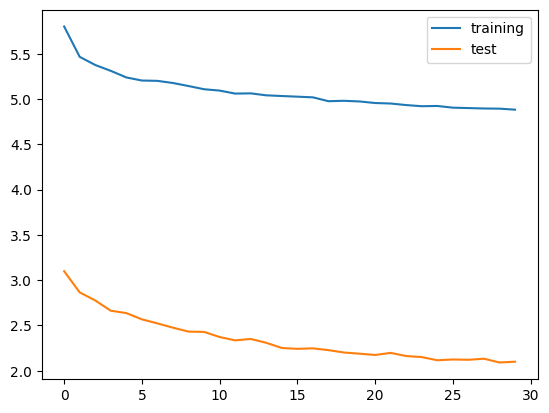

In [34]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

In [49]:
train_loader = DataLoader(train_iter, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(valid_iter, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

with torch.no_grad():
  for src, trg in test_loader:
    src = torch.LongTensor(src).to(device)
    print('src: {}'.format(src.shape)) 
    trg = torch.zeros(src.shape, dtype=int)
    print(trg.shape)
    trg = trg.to(device)
    output = model(src, trg, 0)
    break

print(output.shape) #(trg_len, batch_size, trg_vocab_size)

/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


src: torch.Size([35, 512])
torch.Size([35, 512])
torch.Size([35, 512, 9797])


In [79]:
n = 10

In [80]:
source = ''
for token in src[:,n]:
  source += de_vocab.get_itos()[token] + ' '
print(source)

<sos> ein kleines kind steht allein auf einem zerklüfteten felsen . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


In [81]:
print(output[:,n].shape)

torch.Size([35, 9797])


In [82]:
data = output[:,n].cpu().detach()
tokens = np.argmax(data, axis=1)

target = ''
for token in tokens:
  target += en_vocab.get_itos()[token] + ' '
print(target)

<pad> a small child stands on top of a tree . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
